# Capital Bike Share: Linear Regression

## Overview

Bike sharing systems are a means of renting bicycles where the process of obtaining membership, rental, and bike return is automated via a network of kiosk locations throughout a city. Using these systems, people are able rent a bike from a one location and return it to a different place on an as-needed basis. Currently, there are over 500 bike-sharing programs around the world.

The data generated by these systems makes them attractive for researchers because the duration of travel, departure location, arrival location, and time elapsed is explicitly recorded. Bike sharing systems therefore function as a sensor network, which can be used for studying mobility in a city. In this competition, participants are asked to combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.

#### Key steps:

* exploratory data analysis
* train/test split
* feature engineering
* train a model
* cross-validation
* optimize the model iteratively, select features, try different regressors (e.g. Linear Regression, Random Forest Regressor, SVR)
* calculate test score

#### Data Fields

* datetime - hourly date + timestamp  
* season
    * 1 = spring, 2 = summer, 3 = fall, 4 = winter 
* holiday - whether the day is considered a holiday
* workingday - whether the day is neither a weekend nor holiday
* weather 
    * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
    * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
    * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
    * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
* temp - temperature in Celsius
* atemp - "feels like" temperature in Celsius
* humidity - relative humidity
* windspeed - wind speed
* casual - number of non-registered user rentals initiated
* registered - number of registered user rentals initiated
* count - number of total rentals

Import libraries

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder, PolynomialFeatures, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor

from sklearn.model_selection import cross_val_score

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge, RidgeCV, Lasso, ElasticNet

from sklearn.model_selection import GridSearchCV

# 2. import data

Import datasets

In [2]:
df = pd.read_csv('train_dataset.csv')
test = pd.read_csv('test_dataset.csv')

In [3]:
df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


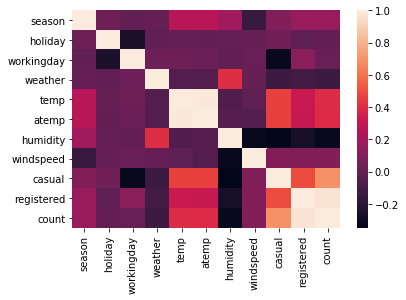

In [4]:
# Pre-eliminatory correlation heatmap:

sns.heatmap(df.corr())

#### Registered vs Casual users: a final review

On a previous data exploratory analysis, both users have shown strong correlation with each other and 'count', therefore not showing much difference in behaviour. In fact, as we can see on samples on the table: Registered + Casual = count, thus we can ignore those variables.

#### Therefore, we define the variables of interest as:

y = df['count']

X = df.drop(['count', 'casual', 'registered'], axis=1)

In [5]:
df.dtypes

datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
count           int64
dtype: object

### Pre-Feature Engineering/ Data cleaning
As we see from the above results, we should convert the datetime column into more specific time-related features for analysis. Moreover, "season","holiday","workingday" and "weather" should be transformed into "categorical" data type, as they are currently integers.

### Create time-related features
Create new df with segragated timestamps

* 1. Set index as column

* 2. Separate out hour and day in new columns

In [6]:
# separate date/time features from datetime

# convert datetime column into datetime type:
df['hour'] = pd.to_datetime(df['datetime']).dt.hour

df['weekday'] = pd.to_datetime(df['datetime']).dt.day_name()

df['day'] = pd.to_datetime(df['datetime']).dt.day

df['month'] = pd.to_datetime(df['datetime']).dt.month

df['year'] = pd.to_datetime(df['datetime']).dt.year

In [7]:
#drop datetime columns
df = df.drop(["datetime"],axis=1)

In [8]:
#No missing values!
df.isnull().sum()

season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
hour          0
weekday       0
day           0
month         0
year          0
dtype: int64

### Look for outliers

[Text(0, 0.5, 'Count'),
 Text(0.5, 0, 'Working Day'),
 Text(0.5, 1.0, 'Box Plot On Count Across Working Day')]

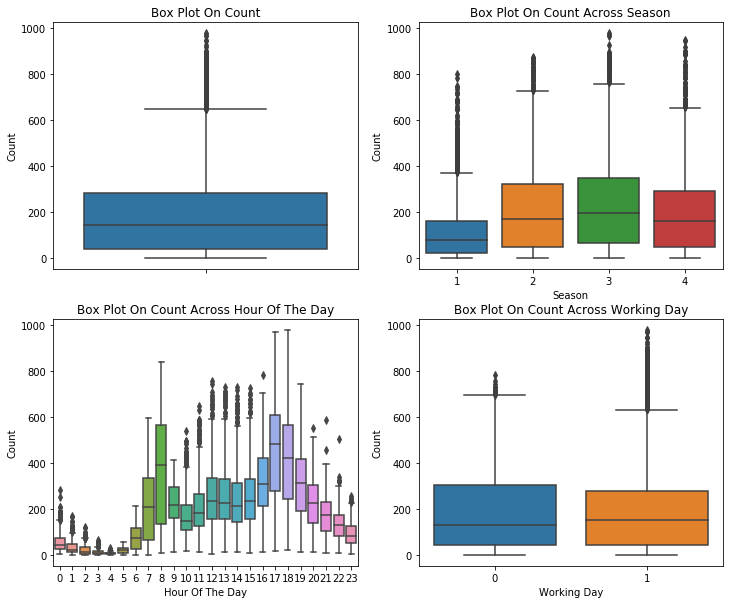

In [9]:
fig, axes = plt.subplots(nrows=2,ncols=2)
fig.set_size_inches(12, 10)
sns.boxplot(data=df,y="count",orient="v",ax=axes[0][0])
sns.boxplot(data=df,y="count",x="season",orient="v",ax=axes[0][1])
sns.boxplot(data=df,y="count",x="hour",orient="v",ax=axes[1][0])
sns.boxplot(data=df,y="count",x="workingday",orient="v",ax=axes[1][1])

axes[0][0].set(ylabel='Count',title="Box Plot On Count")
axes[0][1].set(xlabel='Season', ylabel='Count',title="Box Plot On Count Across Season")
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Count',title="Box Plot On Count Across Hour Of The Day")
axes[1][1].set(xlabel='Working Day', ylabel='Count',title="Box Plot On Count Across Working Day")

As we can see in the boxplots, there are outliers in the count column -- our y. Let's thus remove those outliers:

In [10]:
#removing outlier by values of z-score above 3
df1 = df[np.abs(df["count"]-df["count"].mean())<=(3*df["count"].std())]
print ("Shape Before: ",df.shape)
print ("Shape without Outliers: ",df1.shape)

Shape Before:  (10886, 16)
Shape without Outliers:  (10739, 16)


# 3. train/test split

In [11]:
y = df1['count']
X = df1.drop(['count', 'casual', 'registered'], axis=1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=10)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8054, 13), (2685, 13), (8054,), (2685,))

# 4. exploratory data analysis

In [13]:
train_data = X_train.join(y_train)

In [14]:
train_data.head(2)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,day,month,year,count
3046,3,0,1,1,28.70,32.575,51,15.0013,20,Friday,15,7,2011,343
5048,4,0,0,1,13.12,16.665,81,8.9981,10,Sunday,4,12,2011,216


In [15]:
train_data.shape

(8054, 14)

Text(0.5, 1.0, 'Season by total counts')

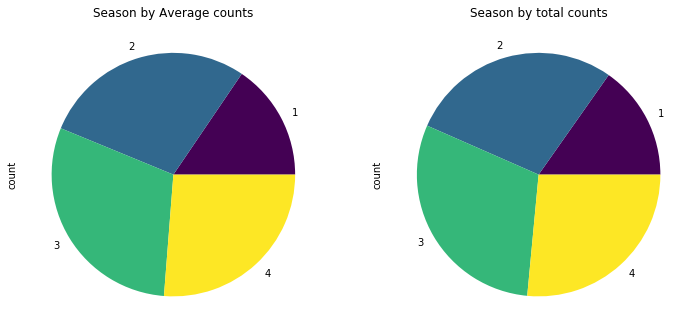

In [16]:
plt.figure(figsize=(12,12))

plt.subplot(1,2,1)
train_data.groupby(["season"])["count"].mean().plot.pie(legend = False, cmap='viridis')
plt.title("Season by Average counts")

plt.subplot(1,2,2)
train_data.groupby(["season"])["count"].sum().plot.pie(legend = False, cmap='viridis')
plt.title("Season by total counts")

### Correlation analysis

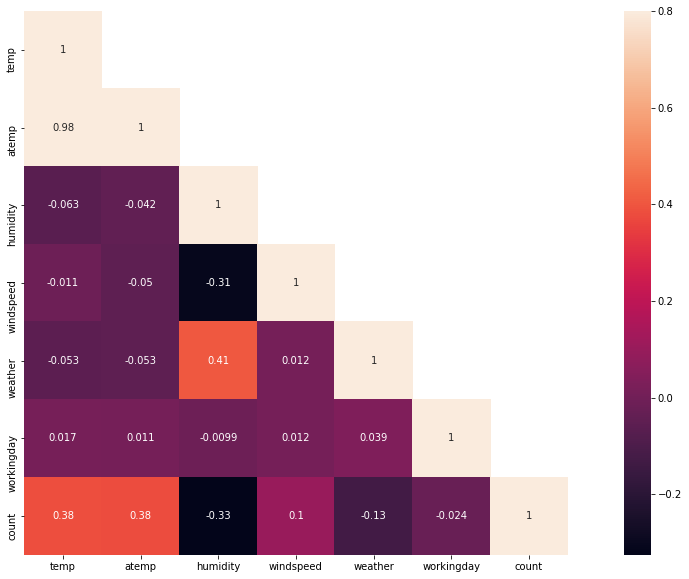

In [39]:
corrm = train_data[["temp","atemp","humidity","windspeed","weather", "workingday","count"]].corr()
mask = np.array(corrm)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrm, mask=mask,vmax=.8,square=True,annot=True)

In [18]:
#Correlations with count on the weekends

train_data[train_data['workingday'] == 0].drop(columns=['year','month','day']).corr()[['count']]

,count
season,0.164921
holiday,-0.000064
workingday,NaN
weather,-0.150938
temp,0.497508
atemp,0.495643
humidity,-0.441698
windspeed,0.123941
hour,0.387113
count,1.000000


#### On the weekends, the strongest correlations with bike checkouts:

* atemp and temp: 50%
* humidity: -42%
* Hour: 39%
* Weather: -14%

In [19]:
train_data["season"] = train_data.season.map({1: "Spring", 2 : "Summer", 3 : "Fall", 4 :"Winter" })
train_data["month"] = train_data.month.map({1:"January", 2:"February", 3:"March", 4:"April", 5:"May", 6:"June",
                                             7:"July", 8:"August", 9:"September", 10:"October", 11:"November", 12:"December"})

[Text(0, 0.5, 'Users Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Users Count By Hour Of The Day Across Weekdays'),
 None]

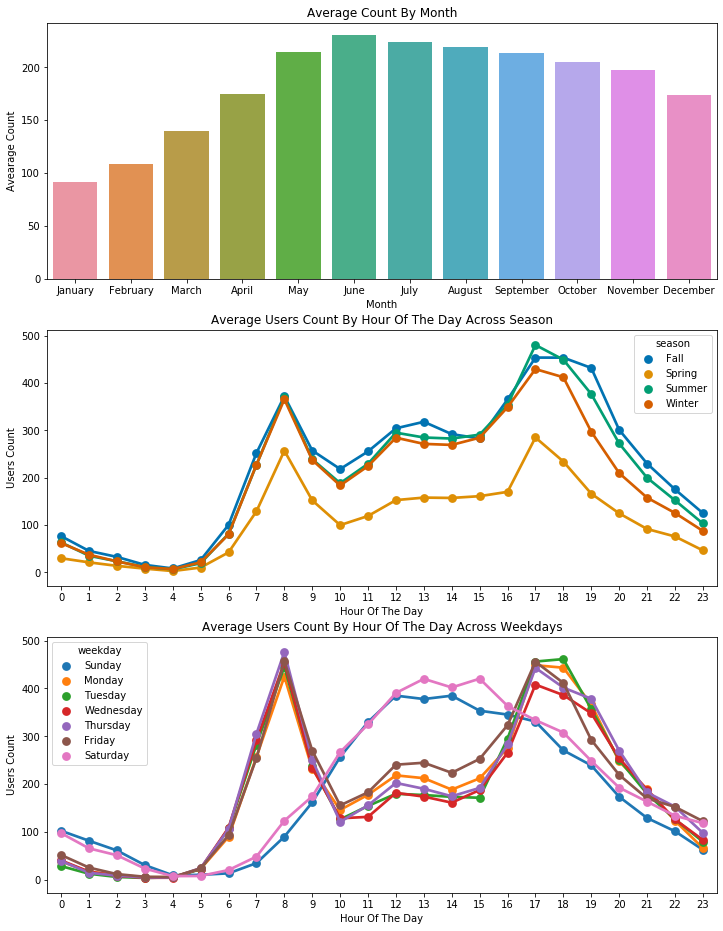

In [22]:
fig,(ax1,ax2,ax3)= plt.subplots(nrows=3)
fig.set_size_inches(12,16)
sortOrder = ["January","February","March","April","May","June","July","August","September","October","November","December"]
hueOrder = ["Sunday","Monday","Tuesday","Wednesday","Thursday","Friday","Saturday"]

monthAggregated = pd.DataFrame(train_data.groupby("month")["count"].mean()).reset_index()
monthSorted = monthAggregated.sort_values(by="count",ascending=False)
sns.barplot(data=monthSorted,x="month",y="count",ax=ax1, order=sortOrder)
ax1.set(xlabel='Month', ylabel='Avearage Count',title="Average Count By Month")

hourAggregated = pd.DataFrame(train_data.groupby(["hour","season"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["season"],palette ='colorblind', data=hourAggregated, join=True,ax=ax2)
ax2.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Season",label='big')

hourAggregated = pd.DataFrame(train_data.groupby(["hour","weekday"],sort=True)["count"].mean()).reset_index()
sns.pointplot(x=hourAggregated["hour"], y=hourAggregated["count"],hue=hourAggregated["weekday"], hue_order=hueOrder, data=hourAggregated, join=True,ax=ax3)
ax3.set(xlabel='Hour Of The Day', ylabel='Users Count',title="Average Users Count By Hour Of The Day Across Weekdays",label='big')

As this graph points out, the weekend -- Saturday and Sunday -- has clearly a different trend throughout the day when compared to weekdays. In fact, at the time we want to predict, Saturday at 14h, there is a peak in checked-out bikes. 12h to 15h seems to be the peak hours of bike rentals during the weekends. 

.
.
.

also shown through:

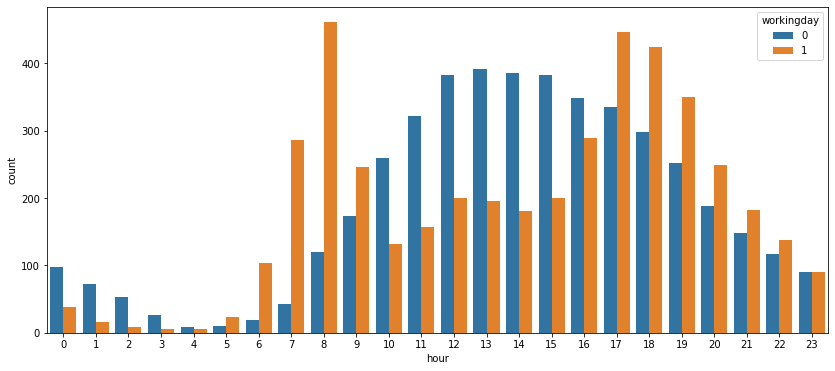

In [24]:
hours = train_data.groupby(['hour', 'workingday']).mean()
hours.reset_index(inplace = True)

plt.figure(figsize=(14,6))
sns.barplot(x = 'hour', y = 'count', data = hours, hue = 'workingday')

#### Which factors seem to have the strongest correlation with Count?:
* Temp and atemp have strong positive correlation with count
* Season also shows positive correlation with count
* Weather and humidity have small negative correlation with count

other takes: 
* Weather and humidty are strongly correlated
* Windspeed and humidity are negatively correlated
* Season has positive correlation with temp


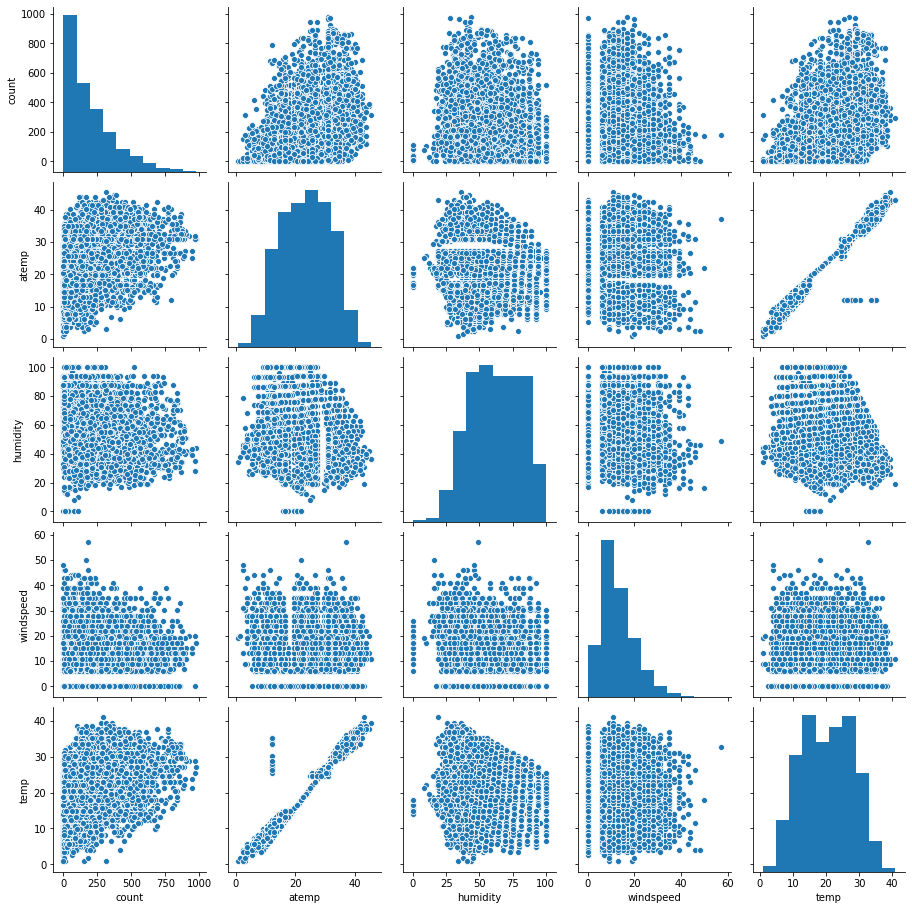

In [23]:
# Analyzing Pair Plot
df_2 = train_data[["count","atemp", "humidity", "windspeed","temp"]]

sns.pairplot(df_2)
plt.show()

The only apparent linear relationship on the graphs, relating with Count, is temp and atemp


### Analyze weather and season

In [31]:
df1.groupby('weather').count()

,season,holiday,workingday,temp,atemp,humidity,windspeed,casual,registered,count,hour,weekday,day,month,year
weather,,,,,,,,,,,,,,,
1,7076,7076,7076,7076,7076,7076,7076,7076,7076,7076,7076,7076,7076,7076,7076
2,2809,2809,2809,2809,2809,2809,2809,2809,2809,2809,2809,2809,2809,2809,2809
3,853,853,853,853,853,853,853,853,853,853,853,853,853,853,853
4,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


Only once Weather 4 is shown in the dataset, thus an analysis on its pattern is not possible

In [30]:
df1.corr()[['season']]

,season
season,1.000000
holiday,0.030368
workingday,-0.011228
weather,0.008989
temp,0.258933
atemp,0.265098
humidity,0.192185
windspeed,-0.147608
casual,0.094550
registered,0.160967


#### Season is highly correlated with month, almost 100%, therefore we can choose only one of them as a feature.

same for holidays and non workindays, atemp and temp, weather and humidty, etc.

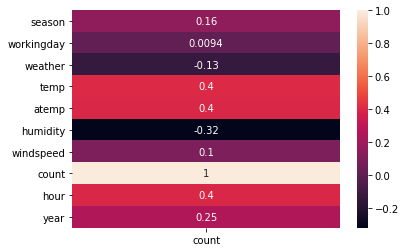

In [27]:
sns.heatmap(train_data.drop(columns=['month', 'holiday', 'day']).corr()[['count']], annot=True)

((array([-3.75677437, -3.52858618, -3.40316581, ...,  3.40316581,
          3.52858618,  3.75677437]),
  array([0.69314718, 0.69314718, 0.69314718, ..., 6.5971457 , 6.59850903,
         6.5998705 ])),
 (1.3454375069607722, 4.567183130405965, 0.9576832913183109))

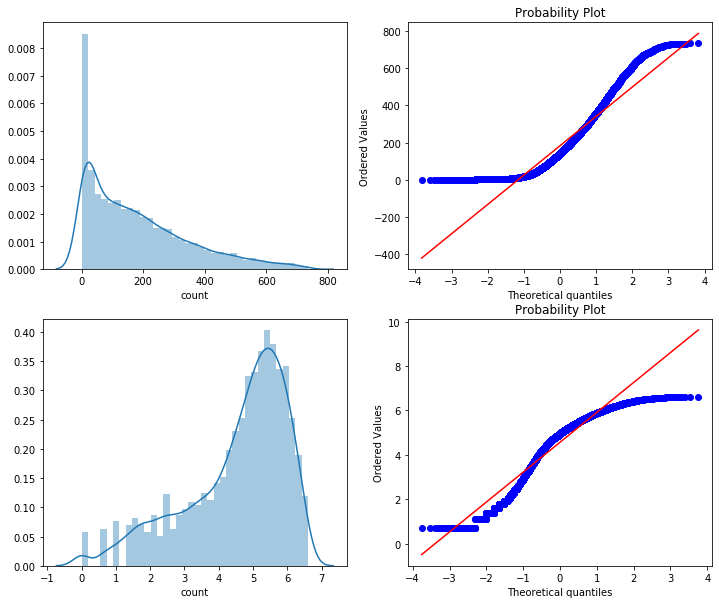

In [32]:
fig,axes = plt.subplots(ncols=2,nrows=2)
fig.set_size_inches(12, 10)
sns.distplot(df1["count"],ax=axes[0][0])
stats.probplot(df1["count"], dist='norm', fit=True, plot=axes[0][1])
sns.distplot(np.log(train_data["count"]),ax=axes[1][0])
stats.probplot(np.log1p(train_data["count"]), dist='norm', fit=True, plot=axes[1][1])

## Final considerations

### Important features that impact the number of bicycles being checkout:
* temp and atemp
* hour
* humidity
* weather
* month
* workinday x hour

### "Count" hasn't a normal distribution
The distribution is skewed towards the right. It is desirable to have Normal: solution is to take log transformation on "count" variable.

In [48]:
feature_list = ['temp', 'atemp','workingday', 'hour', 'month', 'weather', 'humidity']
y = np.log1p(df1["count"])

----

# 5. feature engineering

In [49]:
X_train = (df1[feature_list])
y_train = y

In [50]:
X_train.head(2)

,temp,atemp,workingday,hour,month,weather,humidity
0,9.84,14.395,0,0,1,1,81
1,9.02,13.635,0,1,1,1,80


Time features extracted from df based on EDA: hour, year, day of the week

In [51]:
# Extract the hour of the day from the datetime
def create_timefs(df):
    df = df.copy()
    df['hour'] = pd.to_datetime(df['datetime']).dt.hour
    df['month'] = pd.to_datetime(df['datetime']).dt.month
    return df

In [52]:
create_timefs(X_train)

KeyError: 'datetime'

In [32]:
dummy_features = ['workingday','season','hour']
interaction_features = ['workingday', 'hour','humidity','season','atemp', 'weather']
passthrough_features = ['atemp', 'windspeed', 'humidity', 'year', 'hour']

In [33]:
column_transformer = ColumnTransformer(transformers=[
                        ('dummy', OneHotEncoder(), dummy_features),
                        ('interaction_polynomial', 
                         PolynomialFeatures(interaction_only=True), interaction_features),
                        ('pass', 'passthrough', passthrough_features)
])

In [34]:
transformer_pipeline = Pipeline(steps=[
                        ('create_timefs', FunctionTransformer(create_timefs)),
                        ('column_transformer', column_transformer)
])

In [35]:
X_train_transformed = transformer_pipeline.fit_transform(X_train)

# 6. fit a model

#### baseline model

In [36]:
base_m = DummyRegressor(strategy='median')
base_m.fit(create_timefs(X_train), y_train)

DummyRegressor(strategy='median')

In [37]:
base_m.score(create_timefs(X_train), y_train)

-0.06655615469843612

#### LINEAR REGRESSION

In [38]:
m = LinearRegression()
m.fit(X_train_transformed, y_train)

LinearRegression()

In [39]:
m.score(X_train_transformed, y_train)

0.7226998013136678

# 7. cross validation

In [40]:
m = LinearRegression()
X_train_transformed = transformer_pipeline.fit_transform(X_train)
m.fit(X_train_transformed, y_train)

LinearRegression()

In [41]:
m.score(X_train_transformed, y_train)

0.7226998013136678

In [42]:
cross_val_score(m, X_train_transformed, y_train)

array([0.72212915, 0.7382055 , 0.70585185, 0.71217493, 0.71711795])

# 8. optimize the model

select features, try different regressors (e.g. Linear Regression, Random Forest Regressor, SVR)

### Scaling

In [43]:
scaler = StandardScaler()
scaled_xtrain = scaler.fit_transform(X_train_transformed)

### Try different models

In [44]:
# Choose an alpha parameter
alpha = 2.0

In [45]:
# Lineare Regression
m_lin = LinearRegression()
m_lin.fit(scaled_xtrain, y_train)

# Ridge Regression
m_ridge = Ridge(alpha=alpha)
m_ridge.fit(scaled_xtrain, y_train)

# Lasso Regression
m_lasso = Lasso(alpha=alpha)
m_lasso.fit(scaled_xtrain, y_train)

# ElasticNet Regression
m_elastic = ElasticNet(alpha=alpha, l1_ratio=1)
m_elastic.fit(scaled_xtrain, y_train)

ElasticNet(alpha=2.0, l1_ratio=1)

In [46]:
f'Linear score: {m_lin.score(scaled_xtrain, y_train).round(3)}', f'Ridge score: {m_ridge.score(scaled_xtrain, y_train).round(3)}', f'Lasso score: {m_lasso.score(scaled_xtrain, y_train).round(3)}', f'ElasticNet score: {m_elastic.score(scaled_xtrain, y_train).round(3)}'

('Linear score: 0.723',
 'Ridge score: 0.723',
 'Lasso score: 0.703',
 'ElasticNet score: 0.703')

### GridSearch

In [47]:
linear_regression = Pipeline(steps=[
                        ('transformer', transformer_pipeline),
                        ('regression', LinearRegression())
])

In [48]:
param_grid = {
    'regression': [LinearRegression(), RidgeCV(), Ridge()]
}

grid_search = GridSearchCV(linear_regression, param_grid)

In [49]:
grid_search.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('transformer',
                                        Pipeline(steps=[('create_timefs',
                                                         FunctionTransformer(func=<function create_timefs at 0x7faacafd4f80>)),
                                                        ('column_transformer',
                                                         ColumnTransformer(transformers=[('dummy',
                                                                                          OneHotEncoder(),
                                                                                          ['workingday',
                                                                                           'season',
                                                                                           'hour']),
                                                                                         ('interaction_polynomial',
                                   

In [50]:
pd.DataFrame(grid_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regression,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.031154,0.001439,0.011747,0.000769,LinearRegression(),{'regression': LinearRegression()},0.722129,0.738206,0.705852,0.712175,0.717118,0.719096,0.010969,3
1,0.040394,0.001375,0.011730,0.000336,"RidgeCV(alphas=array([ 0.1, 1. , 10. ]))","{'regression': RidgeCV(alphas=array([ 0.1, 1....",0.722269,0.738089,0.705965,0.712177,0.717044,0.719109,0.010912,1
2,0.026024,0.001079,0.011730,0.000732,Ridge(),{'regression': Ridge()},0.722269,0.738089,0.705965,0.712177,0.717044,0.719109,0.010912,2


# test|

In [51]:
X_test_transformed = transformer_pipeline.fit_transform(X_test)

In [52]:
X_test_transformed.shape

(2722, 57)

In [53]:
m.fit(X_test_transformed, y_test)

m.score(X_test_transformed, y_test)

0.7230827263353138

### test RidgeCV model
as recommended by the GridSearch

In [54]:
ridge_cv = RidgeCV()
ridge_cv.fit(X_test_transformed, y_test)
ridge_cv.score(X_test_transformed, y_test)

0.7230542843338963

In [55]:
cross_val_score(ridge_cv, X_test_transformed, y_test)

array([0.73553561, 0.69015021, 0.69935935, 0.7288486 , 0.70727113])

# THE END